# Mid-IR metalens based on silicon nanopillars

Metamaterial-based lenses, commonly known as metalenses, represent a transformative advancement in the field of optics. Metalenses are flat, ultra-thin, lightweight, and able to focus light at a level that surpasses conventional lenses, all thanks to their intricate sub-wavelength nanostructures.

In practical applications, metalenses hold the promise to revolutionize various sectors from microscopy and imaging to telecommunications and displays. By shrinking the size of the lens without sacrificing the quality of the focused light, they could lead to lighter, more compact optical devices. The integration of metalenses into existing technologies could potentially lead to improvements in medical imaging, smartphones, augmented reality (AR), virtual reality (VR), and many more fields.

This notebook provides a comprehensive illustration of the process involved in the design and simulation of metalens. We initially simulate the phase shifts occurring when light transmits through metasurfaces characterized by varying geometric parameters, i.e. $\phi(d_1, d_2, ...)$, where $d_1, d_2, ...$ are various geometric parameters. Our goal is to examine whether, within the prescribed design parameter range, the phase shift can encompass a spectrum from 0 to 2$\pi$. Concurrently, we also aim to ensure that the transmission maintains a relatively constant level. If these conditions are met, the meta-atoms can be leveraged to construct a metalens. For a focusing lens, we aim to have a transmitted phase profile of $\phi(x,y)=\frac{2\pi}{\lambda_0}(f-\sqrt{x^2+y^2+f^2})$, where $\lambda_0$ is the wavelength and $f$ is the focal length. Finally, combining $\phi(x,y)$ and $\phi(d_1, d_2, ...)$, we can get the meta-atom geometry at each cell position.

Here, we demonstrate the process using the example of a mid-infrared (IR) metalens based on silicon nanopillars as proposed in `Qingbin Fan, Mingze Liu, Cheng Yang, Le Yu, Feng Yan, Ting Xu; A high numerical aperture, polarization-insensitive metalens for long-wavelength infrared imaging. Appl. Phys. Lett. 12 November 2018; 113 (20): 201104` [DOI: 10.1063/1.5050562](https://doi.org/10.1063/1.5050562).

<img src="img/ir_metalens.png" width="500" alt="Schematic of the metalens">

For more lens examples such as the [metalens in the visible frequency range](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/), the [3D optical Luneburg lens](https://www.flexcompute.com/tidy3d/examples/notebooks/OpticalLuneburgLens/), and the [Fresnel lens](https://www.flexcompute.com/tidy3d/examples/notebooks/FresnelLens/), please visit our [examples library](https://www.flexcompute.com/tidy3d/learning-center/example-library/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101 tutorials](https://www.flexcompute.com/tidy3d/learning-center/). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulating Unit Cell Transmission Amplitude and Phase Shift

The metalens is designed for mid-IR. More specifically, for CO$_2$ laser at 10.6 μm wavelength. The meta-atoms consist of cylindrical silicon pillars of different diameters. The height of the pillars is fixed at 6.8 μm and the periodicity of the unit cell is fixed at 6.2 μm.

First, we will set up the unit cell simulation and perform a parameter sweep of the pillar diameter. The result will give us the complex transmission coefficient as a function of the pillar diameter. 

In [2]:
lda0 = 10.6  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency

P = 6.2  # period of the unit cell
h = 6.8  # height of the pillar

inf_eff = 1e5  # effective infinity

Since we are only interested in one particular wavelength, it's unnecessary to consider the material response dispersion. Therefore, we will define the silicon material as a constant refractive index.

In [3]:
n_si = 3.43  # refractive index of silicon
si = td.Medium(permittivity=n_si**2)

To perform the parameter sweep, we define a helper function `make_unit_cell_sim(D)` that creates a Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation) given the pillar diameter. The simulation contains a linearly polarized [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) for excitation and a [DiffractionoMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DiffractionMonitor.html) for measuring the complex transmission coefficient.

In [4]:
# define a function to create pillar given diameter
def make_unit_cell(D):
    pillar_geo = td.Cylinder(center=(0, 0, h / 2), radius=D / 2, length=h)
    pillar = td.Structure(geometry=pillar_geo, medium=si)

    return pillar


# define geometry
substrate_geo = td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0))
substrate = td.Structure(geometry=substrate_geo, medium=si)

# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.1 * lda0),
    direction="+",
)

# define a diffraction monitor to calculate the transmission coefficient
monitor_t = td.DiffractionMonitor(
    center=[0, 0, h + 0.5 * lda0], size=[td.inf, td.inf, 0], freqs=[freq0], name="t"
)

run_time = 5e-12  # simulation run time

# define boundary conditions
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PML(), plus=td.PML()),
)

Lz = h + 1.2 * lda0  # simulation domain size in z direction
min_steps_per_wvl = 12  # minimum steps per wavelength for the grid

# define a function to create unit cell simulation given pillar diameter
def make_unit_cell_sim(D):
    sim = td.Simulation(
        center=(0, 0, h / 2),
        size=(P, P, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
        structures=[make_unit_cell(D), substrate],
        sources=[plane_wave],
        monitors=[monitor_t],
        run_time=run_time,
        boundary_spec=boundary_spec,  # pml is applied to z direction. x and y directions are periodic
    )

    return sim

Before proceeding further, let's create an example simulation and visualize it to ensure the setup is correct.

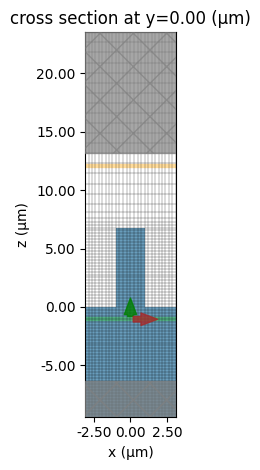

In [5]:
# create an example simulation and visualize the setup and grid
sim = make_unit_cell_sim(2)
ax = sim.plot(y=0)
sim.plot_grid(y=0, ax=ax)
ax.set_aspect(0.8)
plt.show()

Now we are ready to perform the parameter sweep for the pillar diameter from 1.5 μm to 3.6 μm. Since we are only performing a simple sweep for one parameter, we will manually create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) and run it. If the design involves sweeping multiple parameters, it's recommended to use the [design plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/) for convenience in managing the simulations and results.

In [6]:
D_list = np.linspace(1.5, 3.6, 20)  # values of pillar diameter to be simulated

sims = {f"D={D:.3f}": make_unit_cell_sim(D) for D in D_list}  # construct simulation batch

# submit simulation batch to the server
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

15:13:32 BST Started working on Batch containing 20 tasks.

15:15:22 BST Maximum FlexCredit cost: 0.500 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:15:34 BST Batch complete.

Output()

After the simulations are complete, we extract the complex transmission coefficients from each simulation. 

In [7]:
# extract the complex transmission coefficient
t = np.zeros(len(D_list), dtype="complex")
for i, D in enumerate(D_list):
    sim_data = batch_results[f"D={D:.3f}"]
    t[i] = np.array(sim_data["t"].amps.sel(f=freq0, polarization="p"))[0][0]

From the complex transmission coefficient, the phase and transmittance can be calculated and plotted as a function of the pillar diameter. Here we see that the phase of the transmitted field varies from 0 to $2\pi$, which is necessary for creating a metalens. 

Ideally the transmittance is relatively high and uniform. From the transmittance plot, we can see that there is some variation, which could potentially lead to suboptimal performance of the designed metalens. However, we should still be able to use this design to obtain a reasonable metalens. 

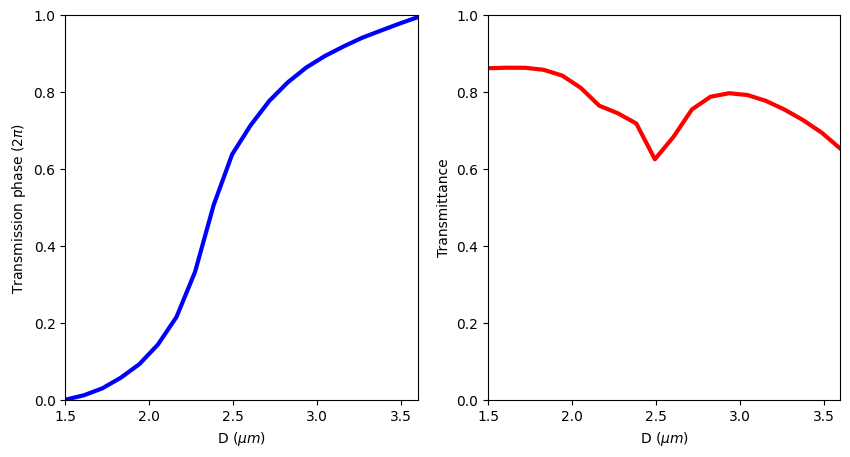

In [8]:
# plot the transmission phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = np.unwrap(np.angle(t))
theta = theta - theta[0]
ax1.plot(D_list, theta / (2 * np.pi), linewidth=3, c="blue")
ax1.set_xlim(np.min(D_list), np.max(D_list))
ax1.set_ylim(0, 1)
ax1.set_xlabel("D ($\mu m$)")
ax1.set_ylabel("Transmission phase ($2\pi$)")

# plot the transmittance
ax2.plot(D_list, np.abs(t), linewidth=3, c="red")
ax2.set_xlim(np.min(D_list), np.max(D_list))
ax2.set_ylim(0, 1)
ax2.set_xlabel("D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()

## Constructing the Full Metalens

With the relationship between the transmission phase and the pillar diameter, we can proceed to design the full metalens. For a focusing lens, we aim to have a transmitted phase profile of $\phi(x,y)=\frac{2\pi}{\lambda_0}(f-\sqrt{x^2+y^2+f^2})$, where $\lambda_0$ is the wavelength and $f$ is the focal length. 

In this specific case, we design a metalens of 100 wavelengths in diameter and a numerical aperture (NA) of 0.6. This results in a ~1 mm metalens with a focal length of ~0.7 mm. In principle, a much larger metalens (cm scale) can be designed and simulated in a similar fashion. 

Due to the mirror symmetry, we only need to include a quarter of the metalens. In the simulation, we will apply the appropriate symmetry condition such that we effectively simulate the entire metalens.

The number of unit cells is 7396.
The diameter of the metalens is 1.060 mm. The focal length is 0.707 mm.


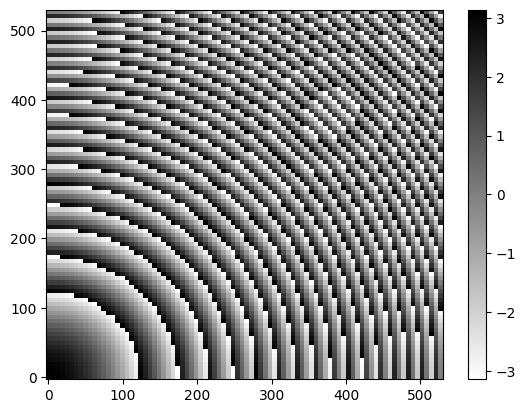

In [9]:
R = 50 * lda0  # radius of the designed metalens

# define a grid of cells
r = np.arange(0, R, P)
print(f"The number of unit cells is {len(r)**2}.")
X, Y = np.meshgrid(r, r)

NA = 0.6  # numerical aperture of the designed metalens

f = R / NA * np.sqrt(1 - NA**2)  # focal length
print(f"The diameter of the metalens is {2*R/1e3:.3f} mm. The focal length is {f/1e3:.3f} mm.")

# desired phase profile
phi_map = (2 * np.pi * (f - np.sqrt(X**2 + Y**2 + f**2)) / lda0) % (-2 * np.pi) + np.pi

# plot the desired phase profile
plt.pcolormesh(X, Y, phi_map, cmap="binary")
plt.colorbar()
plt.show()

With the desired phase distribution, we can perform inverse interpolation and create pillars of appropriate size at each cell. 

In [10]:
# create pillar geometries at each cell to follow the desired phase profile
pillars_geo = []
D_vals = []
theta = np.unwrap(np.angle(t))
for i, x in enumerate(r):
    for j, y in enumerate(r):
        if x**2 + y**2 <= R**2 and x >= 0 and y >= 0:
            D = np.interp(phi_map[i, j], theta, D_list)
            D_vals.append(D)
            pillar_geo = td.Cylinder(center=(x, y, h / 2), radius=D / 2, length=h)
            pillars_geo.append(pillar_geo)

# create pillar structure
pillars = td.Structure(geometry=td.GeometryGroup(geometries=pillars_geo), medium=si)

To reduce the computational cost, we will not directly simulate the focal point. Instead, we will simulate only a small area near the metalens and use near field to far field projection to calculate the field distribution at the focal plane. 

In [11]:
# simulation domain size
Lx = 2 * R + lda0
Ly = 2 * R + lda0
Lz = h + 1.3 * lda0

# grids of the projected field position
xs_far = np.linspace(-3 * lda0, 3 * lda0, 101)
ys_far = np.linspace(-3 * lda0, 3 * lda0, 101)

# define a field projection monitor
monitor_proj = td.FieldProjectionCartesianMonitor(
    center=[0, 0, h + 0.6 * lda0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="focal_plane_proj",
    proj_axis=2,
    proj_distance=f,
    x=xs_far,
    y=ys_far,
    custom_origin=(0, 0, 0),
    far_field_approx=False,
)

# define the simulation
sim = td.Simulation(
    center=(0, 0, Lz / 2 - lda0 / 2),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
    structures=[substrate, pillars],
    sources=[plane_wave],
    monitors=[monitor_proj],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml()),
    symmetry=(-1, 1, 0),
)

Once the simulation is set up, we can visualize the metalens. 

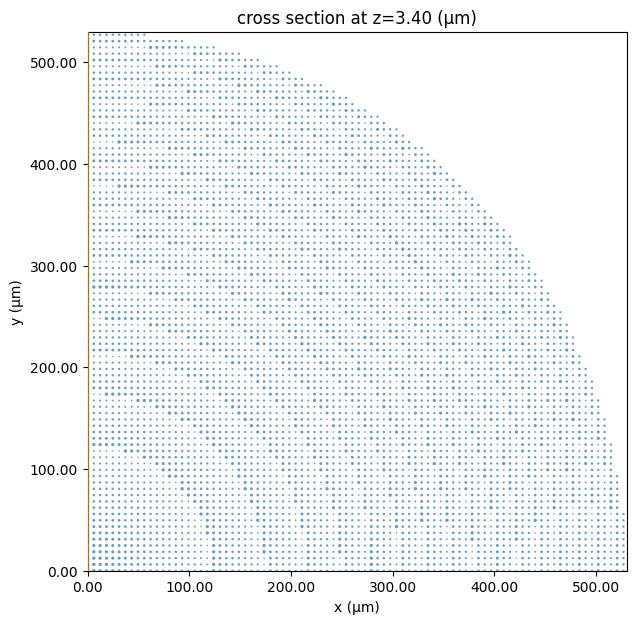

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
sim.plot(z=h / 2, ax=ax)
ax.set_xlim(0, R)
ax.set_ylim(0, R)
plt.show()

Before submitting large simulations to the server, it's always a good practice to estimate the cost first to avoid accidentally wasting your FlexCredicts.

In [13]:
job = web.Job(simulation=sim, task_name="ir_metalens")
estimated_cost = web.estimate_cost(job.task_id)

15:15:54 BST Created task 'ir_metalens' with task_id                            
             'fdve-429559db-b5eb-4412-a6c7-e585f0b3a869' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=43608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=455331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\taskId]8;;\]8;id=43608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\=]8;;\]8;id=270755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\fdve]8;;\]8;id=43608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\-429559db-b5e]8;;\
             ]8;id=43608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\b-4412-a6c7-e585f0b3a869']8;;\.

Output()

15:16:03 BST Maximum FlexCredit cost: 1.238. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

               0.076 FlexCredit of the total cost from post-processing.

Once we confirm the cost is reasonable, we can go ahead and run the simulation.

In [14]:
sim_data = job.run(path="data/new_tom_metalens_simulation_data.hdf5")

15:16:04 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:16:21 BST status = preprocess

15:16:28 BST Maximum FlexCredit cost: 1.238. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

15:16:29 BST running solver

Output()

15:17:50 BST early shutoff detected at 56%, exiting.

             status = postprocess

Output()

15:17:51 BST status = success

             View simulation result at                                          
             ]8;id=929504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=455544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\taskId]8;;\]8;id=929504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\=]8;;\]8;id=838359;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\fdve]8;;\]8;id=929504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\-429559db-b5e]8;;\
             ]8;id=929504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-429559db-b5eb-4412-a6c7-e585f0b3a869\b-4412-a6c7-e585f0b3a869']8;;\.

Output()

15:17:55 BST loading simulation from data/new_tom_metalens_simulation_data.hdf5

## Analyzing the Focusing

After the simulation is done, we can extract and plot the field intensity at the focal plane.

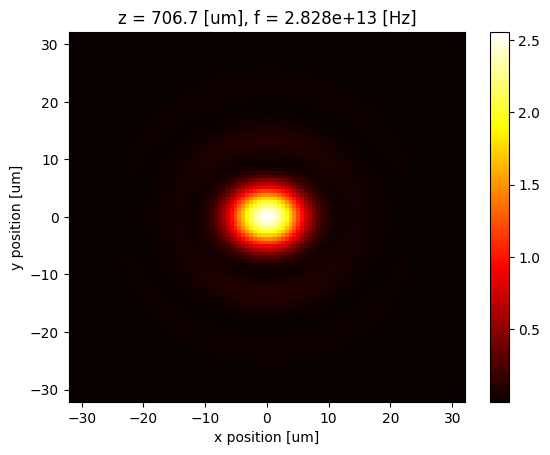

In [15]:
proj_fields = sim_data["focal_plane_proj"].fields_cartesian.sel(f=freq0)

# compute the intensity of the field
I = np.abs(proj_fields.Ex) ** 2 + np.abs(proj_fields.Ey) ** 2 + np.abs(proj_fields.Ez) ** 2

# plot field distribution
I.plot(x="x", y="y", cmap="hot")
plt.show()

More quantitatively, we can find the full width at half maximum (FWHM) of the beam spot. Here we demonstrate that for the x direction as an example. The FWHM is found to be comparable to the wavelength.

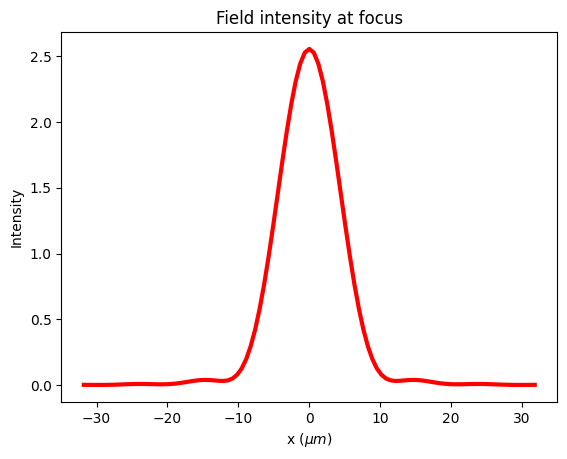

The FWHM is 10.176 um.


In [17]:
I_x = I.sel(y=0, z=f, method="nearest")  # extract the field intensity in the x direction

# plot the intensity profile
fig, ax = plt.subplots()
I_x.plot(linewidth=3, c="red", ax=ax)
ax.set_ylabel("Intensity")
ax.set_xlabel("x ($\mu m$)")
ax.set_title("Field intensity at focus")
plt.show()

# function for determining the fwhm
def cal_fwhm(x, y):

    # filter the data
    y = y[x > 0]
    x = x[x > 0]
    x = x[y > 0.4 * np.max(y)]
    y = y[y > 0.4 * np.max(y)]

    # compute half width by interpolation
    hm_point = np.interp(np.max(y) / 2, y, x)

    # compute full width
    fwhm_value = 2 * hm_point

    return fwhm_value

# calculate fwhm
fwhm = cal_fwhm(I_x.x.values, I_x.values)
print(f"The FWHM is {fwhm:.3f} um.")

## GDS Layout Generation

Now that the design and verification are complete, the next step would be to fabricate the metalens and experimentally verify its performance. To do so, we need to generate a GDS layout of the design. Tidy3D provides a convenient function [to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) that generates a GDS layout based on the simulation. Here we can use it to generate the layout and directly use it for fabrication.

Note that even though we only defined a quarter of the full metalens, the gds export function automatically takes symmetry into account and generates the layout for the entire metalens.

<img src="img/metalens_gds.png" width="500" alt="Generated GDS layout of the metalens">

In [18]:
sim.to_gds_file("data/mid_ir_metalens.gds", z=h / 2)